## Image Classification and Object Localization

In this lab, you'll build a CNN from scratch to:
  - classify the main subject in an image
  - localize it by drawing bounding boxes around it.
  
You'll use the MNIST dataset to synthesize a custom dataset for the task:
  - Place each "digit" image on a black canvas of width 75 x 75 at random locations.
  - Calculate the corresponding bounding boxes for those digits.
  
The bounding box prediction can be modeled as a "regression" task which means that the model will predict a numeric value (as opposed to a category).

## Imports

In [2]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

import tensorflow as tf
from matplotlib import pyplot as plt

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.0


## Visualization Utilities

These functions are used to draw bounding boxes around the digits.

### Plot Utilites for Bounding Boxes [Run ME]

In [31]:
#@title Plot Utilities for Bounding Boxes [RUN ME]

im_width = 500
im_height = 500
use_normalized_coordinates = True

def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=[],
                                       thickness=1,
                                       display_str_list=()):
  """Draws bounding boxes on image (numpy array).
  Args:
    image: a numpy array object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list_list: a list of strings for each bounding box.
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  image_pil = PIL.Image.fromarray(image)
  rgbimg = PIL.Image.new("RGBA", image_pil.size)
  rgbimg.paste(image_pil)
  draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness,
                               display_str_list)
  return np.array(rgbimg)
  

def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
  """Draws bounding boxes on image.
  Args:
    image: a PIL.Image object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: a list of strings for each bounding box.
                           
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                               boxes[i, 2], color[i], thickness, display_str_list[i])
        
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=3,
                               display_str=None,
                               use_normalized_coordinates=True):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: string to display in box
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = PIL.ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  


These utilites are used to visualize the data and predictions

## Visulaiztion Utilities [RUN ME]

In [4]:
#@title Visualization Utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. 

You can skip reading it, as there is very
little Keras or Tensorflow related code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (500*n, 500), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*500,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0), [n, 75*75])
  return font_digits, font_labels


# utility to display a row of digits with their predictions
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_labels = labels[indexes]

  n_iou = []
  if len(iou) > 0:
    n_iou = iou[indexes]

  if (len(pred_bboxes) > 0):
    n_pred_bboxes = pred_bboxes[indexes,:]

  if (len(bboxes) > 0):
    n_bboxes = bboxes[indexes,:]


  n_digits = n_digits * 255.0
  print(n_digits.shape)
  n_digits = n_digits.reshape(n, 500, 500, 3)
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  
  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    bboxes_to_plot = []
    if (len(pred_bboxes) > i):
      bboxes_to_plot.append(n_pred_bboxes[i])
    
    if (len(bboxes) > i):
      bboxes_to_plot.append(n_bboxes[i])

    img_to_draw = draw_bounding_boxes_on_image_array(image=np.uint8(n_digits[i]), boxes=np.asarray(bboxes_to_plot), color=['red', 'green'], display_str_list=["true", "pred"])
    plt.xlabel(n_predictions[i])
    plt.xticks([])
    plt.yticks([])
    
    if n_predictions[i] != n_labels[i]:
      ax.xaxis.label.set_color('red')

    
    
    plt.imshow(img_to_draw)

    if len(iou) > i :
      color = "black"
      if (n_iou[i][0] < iou_threshold):
        color = "red"
      ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [5]:
print(tf.config.experimental.list_logical_devices("GPU"))

strategy = tf.distribute.get_strategy()

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Metal device set to: Apple M1


2022-12-21 16:14:24.869980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-21 16:14:24.870984: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Parameters

The global batch size is the batch size per replica (64 in this case) times the number of replicas in the distribution strategy

In [6]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

## Loading an Preprocessing the Dataset

Define some helper functions that will pre-process your data:
  - `read_image_tfds`: ramdomly overlays the "digit" image on top of a larger canvas.
  - `get_training_dataset`:loads data and splits it to get the training set.
  - `get_validation_dataset`: loads and splits the data to get the validation set.

In [7]:
import os

# This should be updated
root_dir = '/Users/lucas/Data_Science_Portfolio/M&M project/M&M_images_cropped'

validation_dir = os.path.join(root_dir, 'validation')
training_dir = os.path.join(root_dir, 'training')

In [51]:
image = PIL.Image.open(os.path.join(training_dir, 'M&Ms/4.jpg'))

In [11]:
from numpy import asarray

numpydata = asarray(image)

print(numpydata/255)

[[[0.78823529 0.74509804 0.65882353]
  [0.79215686 0.74901961 0.6627451 ]
  [0.79215686 0.74901961 0.6627451 ]
  ...
  [0.6627451  0.61960784 0.54117647]
  [0.65882353 0.61568627 0.5372549 ]
  [0.65882353 0.61568627 0.5372549 ]]

 [[0.79215686 0.74901961 0.6627451 ]
  [0.79607843 0.75294118 0.66666667]
  [0.8        0.75686275 0.67058824]
  ...
  [0.6627451  0.61960784 0.54117647]
  [0.66666667 0.62352941 0.54509804]
  [0.66666667 0.62352941 0.54509804]]

 [[0.78431373 0.74117647 0.65490196]
  [0.78823529 0.74509804 0.65882353]
  [0.79607843 0.75294118 0.66666667]
  ...
  [0.6627451  0.61960784 0.54117647]
  [0.6627451  0.61960784 0.54117647]
  [0.66666667 0.62352941 0.54509804]]

 ...

 [[0.78431373 0.74117647 0.6627451 ]
  [0.78039216 0.7372549  0.65882353]
  [0.78039216 0.7372549  0.65882353]
  ...
  [0.69411765 0.6627451  0.58823529]
  [0.69411765 0.6627451  0.58823529]
  [0.69411765 0.6627451  0.58823529]]

 [[0.78431373 0.74117647 0.6627451 ]
  [0.78039216 0.7372549  0.65882353]


Notice that the array is not normalized so we will have to divide by 255.

In [36]:
m_and_ms = os.path.join(training_dir, 'M&Ms')
nots = os.path.join(training_dir, 'Not_M&Ms')

training_images = np.array([])
training_labels = np.array([])

In [37]:
for i in os.listdir(m_and_ms):
    if i != '.DS_Store':
        image = PIL.Image.open(os.path.join(m_and_ms, i))
        numpydata = asarray(image)
        normalized = numpydata/255
        training_images = np.append(training_images, normalized)
        training_labels = np.append(training_labels, 1)

In [18]:
print(len(os.listdir(m_and_ms)))
print(len(training_images))

16
450000


In [38]:
for i in os.listdir(nots):
    if i != '.DS_Store':
        image = PIL.Image.open(os.path.join(nots, i))
        numpydata = asarray(image)
        normalized = numpydata/255
        training_images = np.append(training_images, normalized)
        training_labels = np.append(training_labels, 0)

In [20]:
print(len(os.listdir(nots)))

10


In [39]:
training_images = np.reshape(training_images, (24, 100, 100, 3))

In [15]:
from matplotlib import pyplot as plt


padded = tf.pad(training_images[0], [[100, 200], [100, 200], [0, 0]], mode="CONSTANT", constant_values=0.9)
image_pil = PIL.Image.fromarray(np.uint8(padded*255))

image_pil.save("confused.jpg")

In [41]:
train = np.array([])
training_bboxes = np.array([])

for i in training_images:
    xmin = tf.random.uniform((), 0, 400, dtype=tf.int32)
    ymin = tf.random.uniform((), 0, 400, dtype=tf.int32)
    xmax = xmin + 100
    ymax = ymin + 100
    image = tf.pad(i, [[xmin, 500 - xmax], [ymin, 500 - ymax], [0,0]], mode="CONSTANT", constant_values=0.9)
    train = np.append(train, image)
    training_bboxes = np.append(training_bboxes, [[xmin, ymin, xmax, ymax]])
   
train = np.reshape(train, (24, 500, 500, 3))
print(train.shape)

(24, 500, 500, 3)


In [51]:
training_bboxes = np.reshape(training_bboxes, (24, 4))
print(training_bboxes.shape)

print(train.shape)
print(training_labels.shape)

(24, 4)
(24, 500, 500, 3)
(24,)


In [42]:
m_and_ms = os.path.join(validation_dir, 'M&Ms')
nots = os.path.join(validation_dir, 'Not_M&Ms')

validation_images = np.array([])
validation_labels = np.array([])

In [43]:
for i in os.listdir(m_and_ms):
    if i != '.DS_Store':
        image = PIL.Image.open(os.path.join(m_and_ms, i))
        numpydata = asarray(image)
        normalized = numpydata/255
        validation_images = np.append(training_images, normalized)
        validation_labels = np.append(training_labels, 1)

In [44]:
for i in os.listdir(nots):
    if i != '.DS_Store':
        image = PIL.Image.open(os.path.join(nots, i))
        numpydata = asarray(image)
        normalized = numpydata/255
        validation_images = np.append(training_images, normalized)
        validation_labels = np.append(training_labels, 0)

In [45]:
validation_images = np.reshape(validation_images, (25, 100, 100, 3))

In [46]:
validate = np.array([])
validation_bboxes = np.array([])

for i in validation_images:
    xmin = tf.random.uniform((), 0, 400, dtype=tf.int32)
    ymin = tf.random.uniform((), 0, 400, dtype=tf.int32)
    xmax = xmin + 100
    ymax = ymin + 100
    image = tf.pad(i, [[xmin, 500 - xmax], [ymin, 500 - ymax], [0,0]], mode="CONSTANT", constant_values=0.9)
    validate = np.append(validate, image)
    validation_bboxes = np.append(validation_bboxes, [[xmin, ymin, xmax, ymax]])
   
validate = np.reshape(validate, (25,  500, 500, 3))
print(validate.shape)

(25, 500, 500, 3)


In [47]:
validation_bboxes = np.reshape(validation_bboxes, (25, 4))
print(validation_bboxes.shape)

print(validate.shape)
print(validation_labels.shape)

(25, 4)
(25, 500, 500, 3)
(25,)


(10, 1000, 1000, 3)


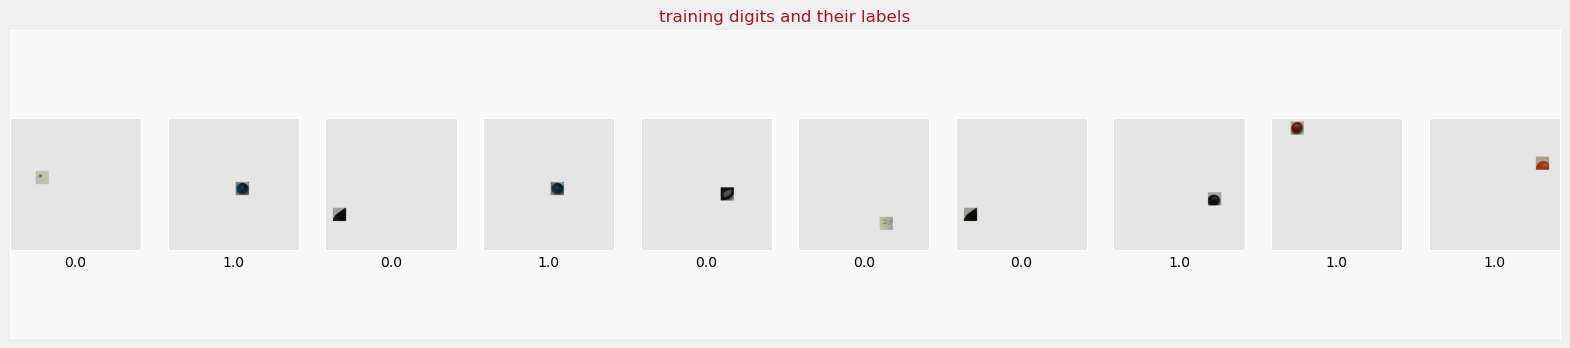

In [32]:
display_digits_with_boxes(train, training_labels, training_labels, np.array([]), training_bboxes, np.array([]), "training digits and their labels")

In [24]:
training_dataset = tf.data.Dataset.from_tensor_slices({'images': np.uint8(train), 'labels': np.uint8(training_labels), 'bounding_boxe': np.uint8(training_bboxes)})
print(training_dataset)

<TensorSliceDataset element_spec={'images': TensorSpec(shape=(1000, 1000, 3), dtype=tf.uint8, name=None), 'labels': TensorSpec(shape=(), dtype=tf.uint8, name=None), 'bounding_boxe': TensorSpec(shape=(4,), dtype=tf.uint8, name=None)}>


In [28]:
validation_dataset = tf.data.Dataset.from_tensor_slices({'images': np.uint8(validate), 'labels': np.uint8(validation_labels), 'bounding_boxe': np.uint8(validation_bboxes)})
print(validation_dataset)

<TensorSliceDataset element_spec={'images': TensorSpec(shape=(1000, 1000, 3), dtype=tf.uint8, name=None), 'labels': TensorSpec(shape=(), dtype=tf.uint8, name=None), 'bounding_boxe': TensorSpec(shape=(4,), dtype=tf.uint8, name=None)}>


In [56]:
'''
Feature extractor is the CNN that is made up of convolution and pooling layers.
'''
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(500, 500, 3))(inputs)
    x = tf.keras.layers.AveragePooling2D((4, 4))(x)

    x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((4, 4))(x)

    x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((4, 4))(x)
    
    x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((4, 4))(x)


    return x

'''
dense_layers adds a flatten and dense layer.
This will follow the feature extraction layers
'''
def dense_layers(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  return x


'''
Classifier defines the classification output.
This has a set of fully connected layers and a softmax layer.
'''
def classifier(inputs):

  classification_output = tf.keras.layers.Dense(1, activation='sigmoid', name = 'labels')(inputs)
  return classification_output


'''
This function defines the regression output for bounding box prediction. 
Note that we have four outputs corresponding to (xmin, ymin, xmax, ymax)
'''
def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(units = '4', name = 'bounding_box')(inputs)
    return bounding_box_regression_output


def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)

    '''
    The model branches here.  
    The dense layer's output gets fed into two branches:
    classification_output and bounding_box_output
    '''
    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_output, bounding_box_output])

    return model
  

def define_and_compile_model(inputs):
  model = final_model(inputs)
  
  model.compile(optimizer='adam', 
              loss = {'labels' : 'binary_crossentropy',
                      'bounding_box' : 'mse'
                     },
              metrics = {'labels' : 'accuracy',
                         'bounding_box' : 'mse'
                        })
  return model

    
with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(500, 500, 3), name="images")
  model = define_and_compile_model(inputs)

# print model layers
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 images (InputLayer)            [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 498, 498, 16  448         ['images[0][0]']                 
                                )                                                                 
                                                                                                  
 average_pooling2d_23 (AverageP  (None, 124, 124, 16  0          ['conv2d_23[0][0]']              
 ooling2D)                      )                                                           

In [26]:
def format_y(labels, bounding_boxes):
    return labels, bounding_boxes

In [57]:
EPOCHS = 45 # 45
steps_per_epoch = 24//BATCH_SIZE  # 60,000 items in this dataset
validation_steps = 1

history = model.fit(train, y = format_y(training_labels, training_bboxes), epochs=EPOCHS, validation_data=(validate, [validation_labels, validation_bboxes]))

Epoch 1/45


2022-12-27 10:48:41.149231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 73953.6094 - labels_loss: 0.6798 - bounding_box_loss: 73952.9219 - labels_accuracy: 0.6250 - bounding_box_mse: 73952.9219

2022-12-27 10:48:43.178353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step - loss: 73953.6094 - labels_loss: 0.6798 - bounding_box_loss: 73952.9219 - labels_accuracy: 0.6250 - bounding_box_mse: 73952.9219 - val_loss: 59765.9648 - val_labels_loss: 0.6945 - val_bounding_box_loss: 59765.2695 - val_labels_accuracy: 0.4000 - val_bounding_box_mse: 59765.2695
Epoch 2/45
1/1 [==============================] - 0s 448ms/step - loss: 73901.4297 - labels_loss: 0.6946 - bounding_box_loss: 73900.7344 - labels_accuracy: 0.3750 - bounding_box_mse: 73900.7344 - val_loss: 59723.4727 - val_labels_loss: 0.7006 - val_bounding_box_loss: 59722.7734 - val_labels_accuracy: 0.4000 - val_bounding_box_mse: 59722.7773
Epoch 3/45
1/1 [==============================] - 0s 454ms/step - loss: 73853.7812 - labels_loss: 0.7019 - bounding_box_loss: 73853.0781 - labels_accuracy: 0.3750 - bounding_box_mse: 73853.0781 - val_loss: 59661.9180 - val_labels_loss: 0.7035 - val_bounding_box_loss: 59661.2188 - val_labels_accuracy: 0.4000 - val_bounding_bo